In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime

In [2]:
# Loading data
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')

# Initial exploration
print(customers.head())
print(transactions.head())
print(engagement.head())
print(marketing.head())


   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

In [3]:
# DATA CLEANING AND PREPARATION

# Converting dates to DateTime
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

# Imputing missing values
customers['age'].fillna(customers['age'].median(), inplace=True)
customers['gender'].fillna('Unknown', inplace=True)
imputer = KNNImputer(n_neighbors=5)
customers[['age']] = imputer.fit_transform(customers[['age']])

# Calculating Months from Join Date to Last Purchase Date
customers['months_active'] = (customers['last_purchase_date'] - customers['join_date']).dt.days // 30
customers['months_active'].replace(0, 1, inplace=True)

# Feature Engineering
monthly_revenue = transactions.groupby('customer_id')['transaction_amount'].sum() / customers['months_active']
customers['CLV'] = monthly_revenue

# RFM analysis
customers['recency'] = (datetime.now() - customers['last_purchase_date']).dt.days
frequency = transactions.groupby('customer_id').size()
customers['frequency'] = customers['customer_id'].map(frequency)
monetary = transactions.groupby('customer_id')['transaction_amount'].sum()
customers['monetary'] = customers['customer_id'].map(monetary)

# Merging with Engagement Data
customers = customers.merge(engagement, on='customer_id', how='left')
customers.fillna(0, inplace=True)

# Positive Engagement Response
customers['click_per_transaction'] = customers['number_of_clicks'] / customers['frequency']
customers['visit_per_transaction'] = customers['number_of_site_visits'] / customers['frequency']
customers['email_per_transaction'] = customers['number_of_emails_opened'] / customers['frequency']

# Calculating response rate
positive_responses = marketing[marketing['response'] == 'Yes'].groupby('customer_id').size()
total_responses = marketing.groupby('customer_id').size()
customers['response_rate'] = customers['customer_id'].map(positive_responses) / customers['customer_id'].map(total_responses)
customers['response_rate'].fillna(0, inplace=True)

C:\Users\aayre\AppData\Local\Temp\ipykernel_12044\1170937327.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['age'].fillna(customers['age'].median(), inplace=True)
C:\Users\aayre\AppData\Local\Temp\ipykernel_12044\1170937327.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

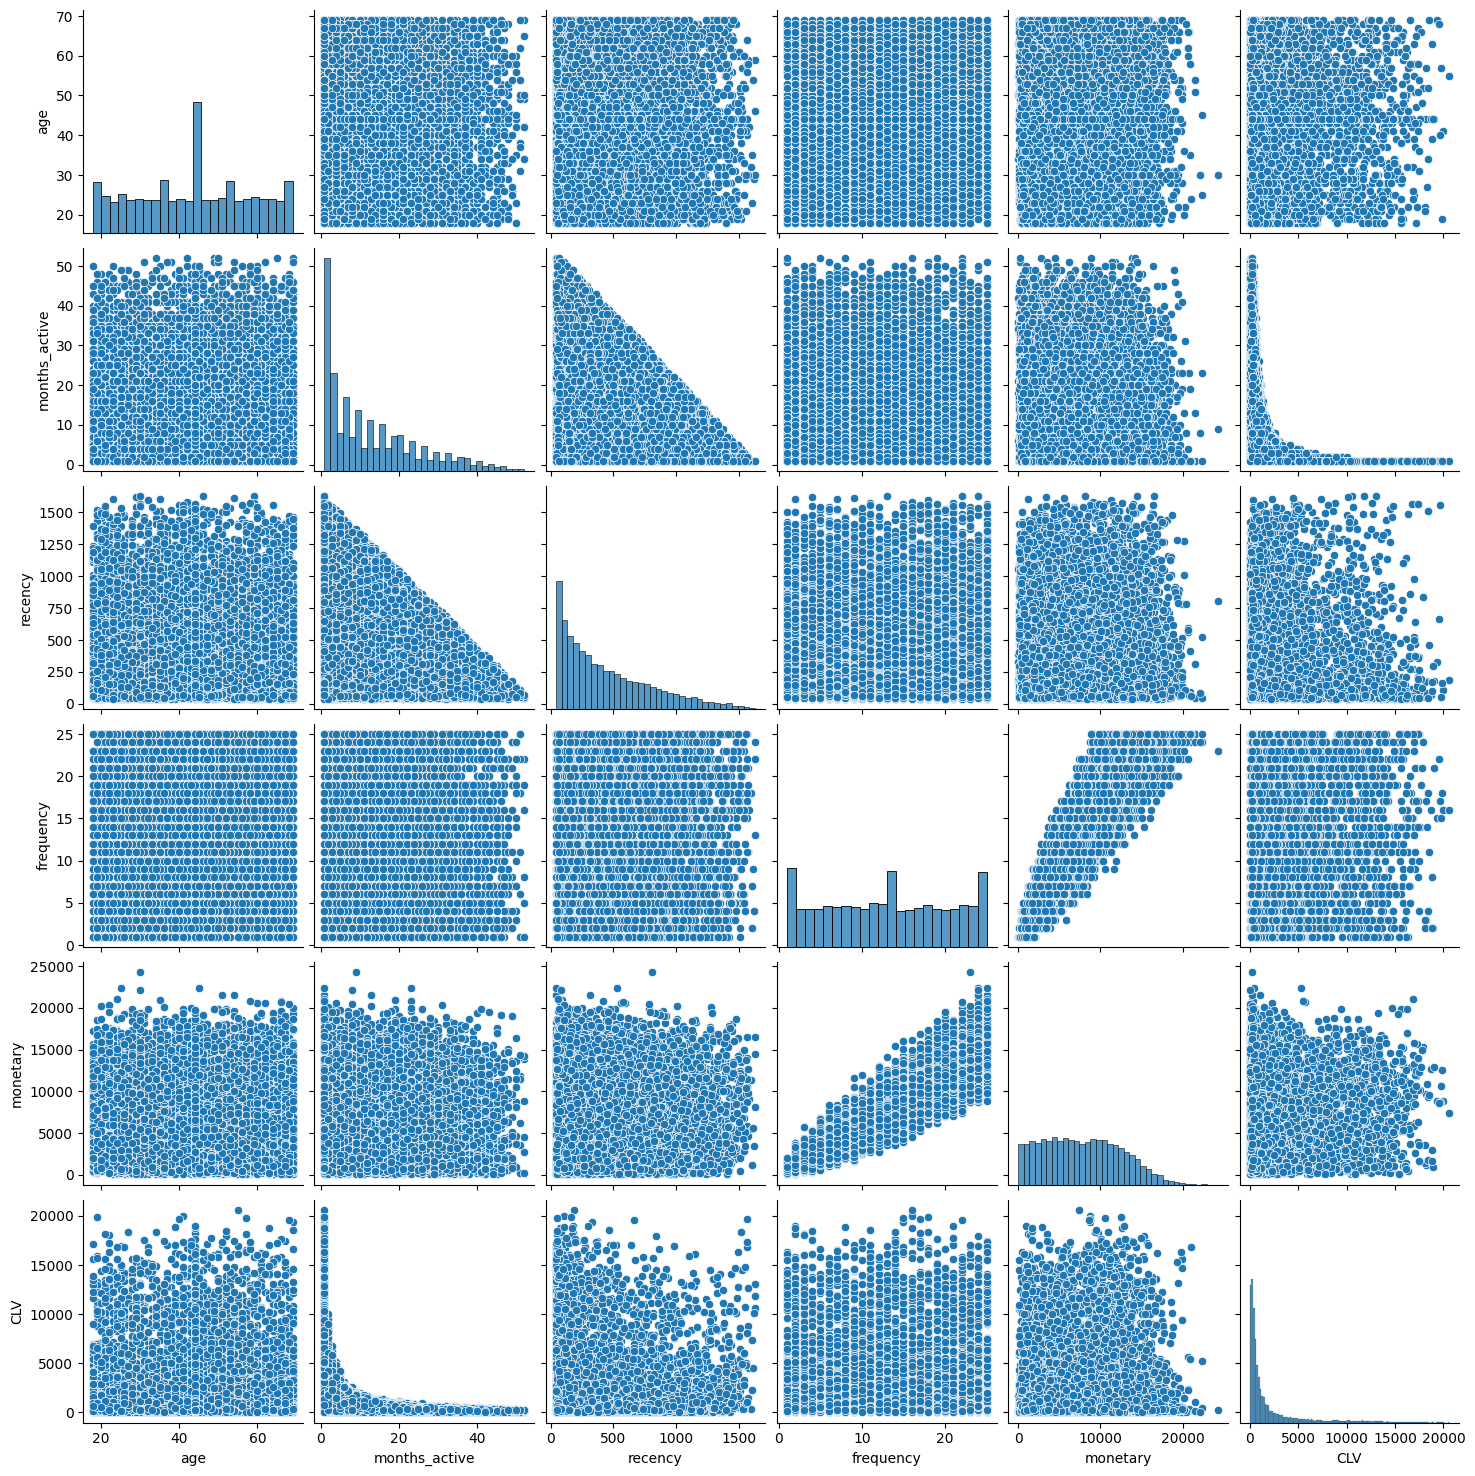

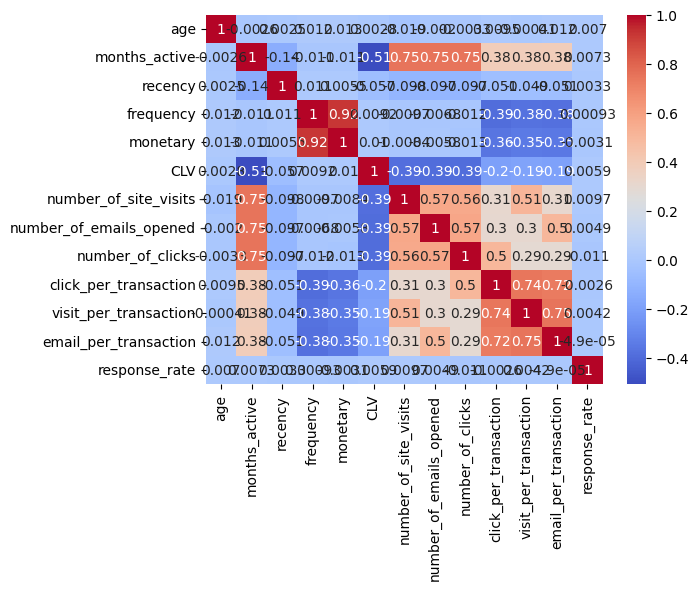

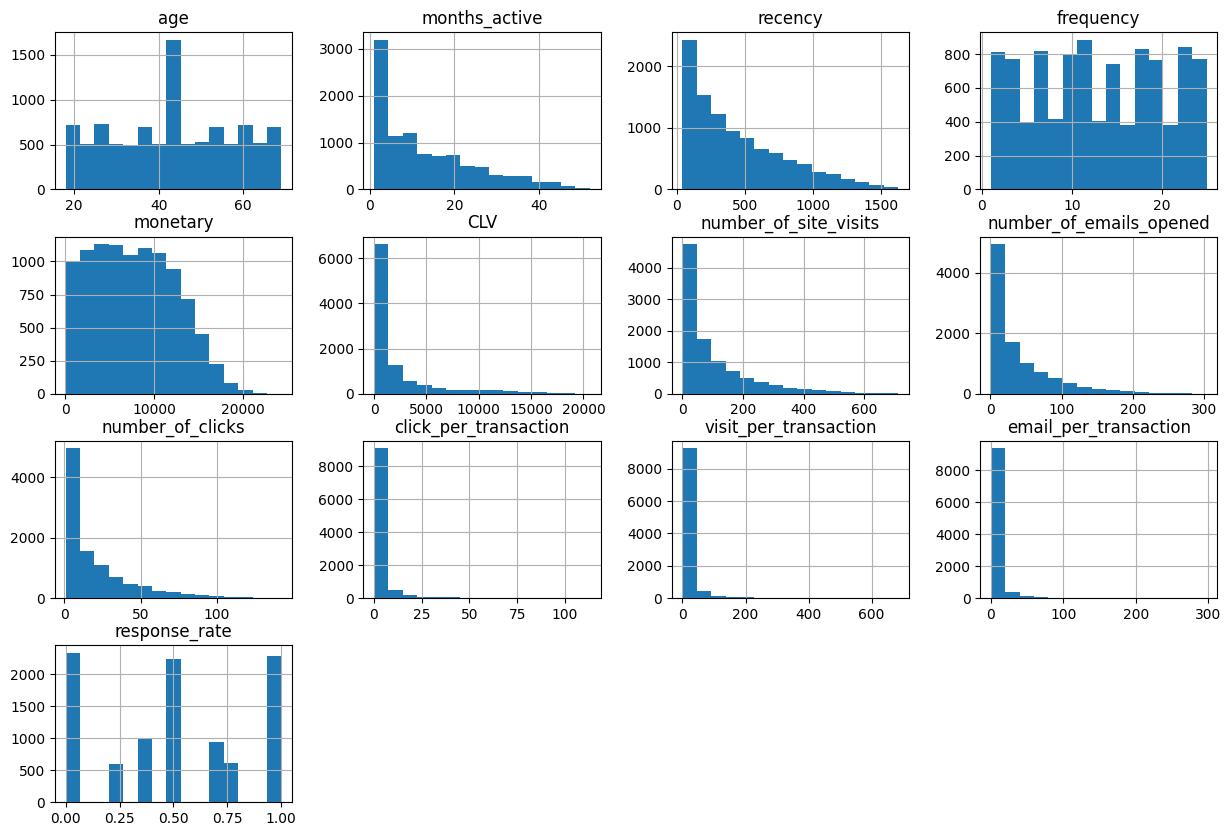

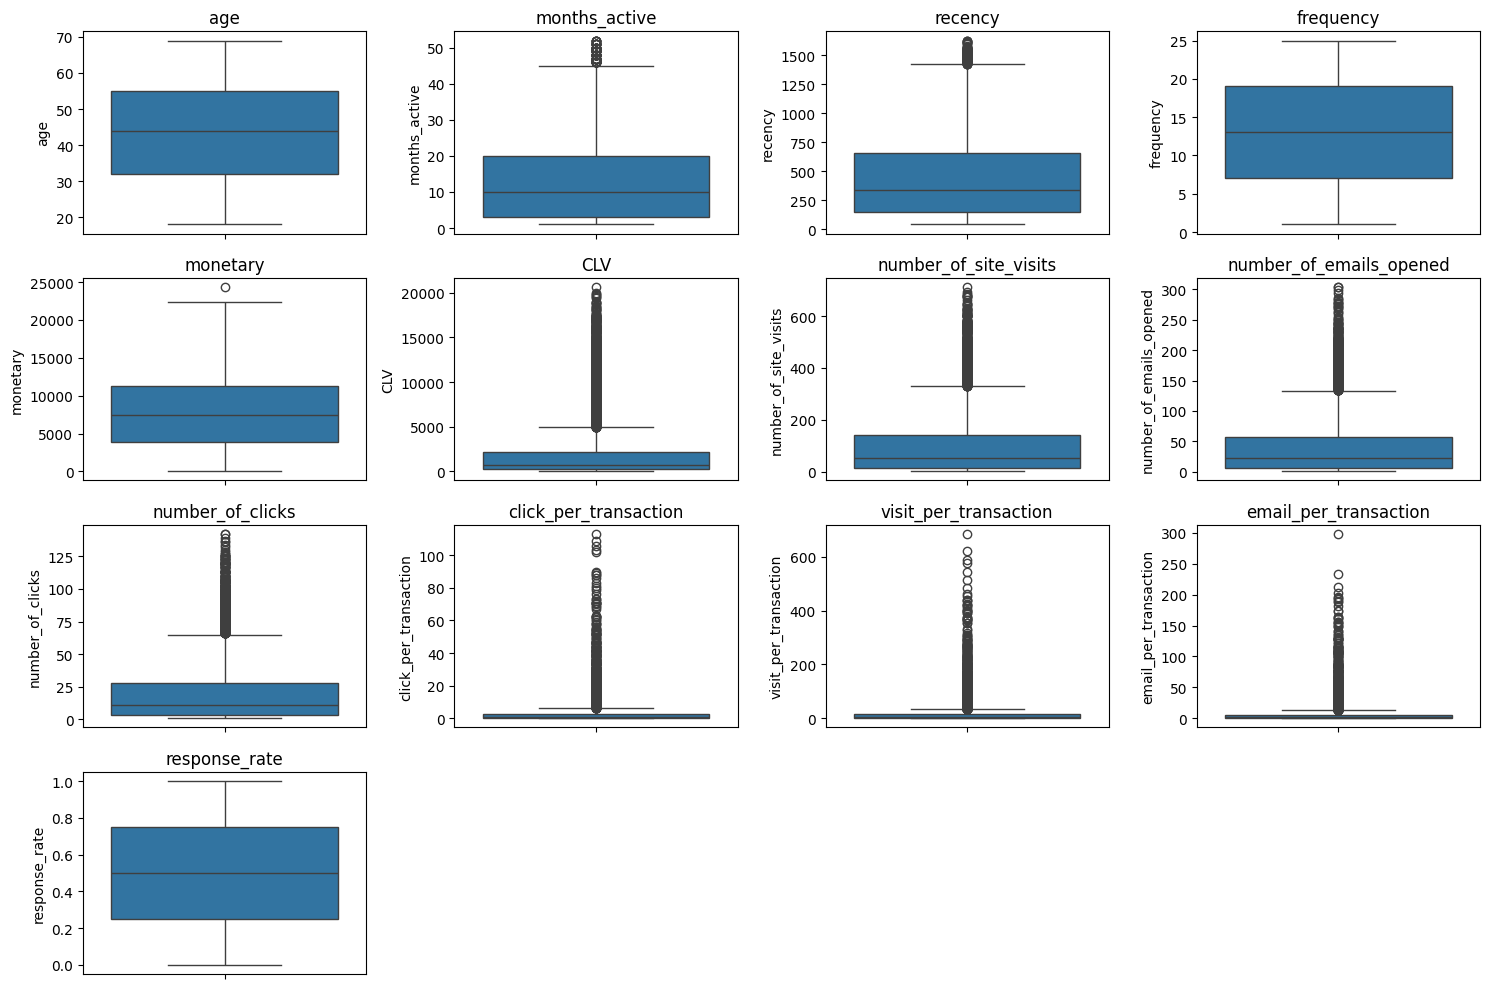

In [4]:
# EXPLORATORY DATA ANALYSIS (EDA)

# Pairplot for initial exploration
sns.pairplot(customers[['age', 'months_active', 'recency', 'frequency', 'monetary', 'CLV']])
plt.show()

# Correlation matrix
numeric_cols = customers[['age', 'months_active', 'recency', 'frequency', 'monetary', 'CLV', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks', 'click_per_transaction', 'visit_per_transaction', 'email_per_transaction', 'response_rate']]
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Histograms for numeric columns
numeric_cols.hist(bins=15, figsize=(15, 10))
plt.show()

# Boxplots to check for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols.columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=numeric_cols[col])
    plt.title(col)
plt.tight_layout()
plt.show()


In [10]:
# Handling Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select features for VIF calculation
X = customers[['age', 'months_active', 'recency', 'frequency', 'monetary', 'click_per_transaction', 'visit_per_transaction', 'email_per_transaction', 'response_rate']]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("Initial VIF values:")
print(vif_data)

# Removing 'monetary' due to high VIF
X = customers[['age', 'months_active', 'recency', 'frequency', 'click_per_transaction', 'visit_per_transaction', 'email_per_transaction', 'response_rate']]

# Recalculate VIF after removing 'monetary'
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("VIF values after removing 'monetary':")
print(vif_data)



Initial VIF values:
                 feature        VIF
0                    age   5.465155
1          months_active   2.783676
2                recency   2.361869
3              frequency  28.715965
4               monetary  25.524194
5  click_per_transaction   3.183841
6  visit_per_transaction   3.363448
7  email_per_transaction   3.213321
8          response_rate   2.644904
VIF values after removing 'monetary':
                 feature       VIF
0                    age  5.463827
1          months_active  2.783668
2                recency  2.361686
3              frequency  4.300910
4  click_per_transaction  3.183716
5  visit_per_transaction  3.363381
6  email_per_transaction  3.213280
7          response_rate  2.644756


In [11]:
# Model Building and Evaluation

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Preparing data for model building
y = customers['CLV']

# Ensure that 'monetary' is not included in the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Random Forest Regressor Model with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
rf_preds = best_rf_model.predict(X_test)

# Model Evaluation
lr_mse = mean_squared_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)
print(f'Linear Regression MSE: {lr_mse}, R2: {lr_r2}')

rf_mse = mean_squared_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)
print(f'Tuned Random Forest MSE: {rf_mse}, R2: {rf_r2}')



Fitting 3 folds for each of 27 candidates, totalling 81 fits
Linear Regression MSE: 8090368.015848575, R2: 0.2582550866774953
Tuned Random Forest MSE: 4180092.408199969, R2: 0.6167588081374643


## Summary and Business Impact Analysis

### Data Preparation Approach
- Imputed missing values using median and KNN imputer.
- Converted date columns to datetime format.
- Created new features (e.g., recency, frequency, monetary, CLV, engagement metrics).

### Key Insights
- Customers with higher frequency and monetary value tend to have higher CLV.
- Positive engagement responses (clicks, visits, emails) correlate with higher CLV.

### Model Selection, Performance, and Justification
- Linear Regression: MSE = {lr_mse}, R2 = {lr_r2}
- Random Forest Regressor: MSE = {rf_mse}, R2 = {rf_r2}
- Random Forest performed better due to its ability to handle non-linear relationships and interactions between variables.
- Hyperparameter tuning further improved the Random Forest model's performance.

### Estimated Impact to the Business
- Identifying high-value customers allows for targeted marketing strategies.
- Predicting CLV helps in resource allocation and improving customer retention.
- By focusing marketing efforts on high CLV customers, EcomX can increase revenue and customer loyalty.
- Efficient resource management for low CLV customers can reduce costs and improve overall profitability.
